In [63]:
import json
import os
import copy
import random 
import numpy as np
from client import *
import matplotlib.pyplot as plt
import datetime

In [64]:
Team_Key = "VPN75t7UGO44XsrQlo9KuKkg8yRrqgSfyh13GITsQnyvLLyvV5" 
Team_Name = "Platypus_Perry"
max_limit = 10 
min_limit = -10
generations = 10
array_len = 11
population_size = 14
chromosome_size = 11
Mutation_Probability = 0.2         # probabilty that it will mutate
Mutation_Difference_Scale = 1000   # adding noice on mutation to actual value ratio
initial_array = [0.0, -1.45799022e-12, -2.28980078e-13,  4.62010753e-11, -1.75214813e-10, -1.83669770e-15,  8.52944060e-16,  2.29423303e-05, -2.04721003e-06, -1.59792834e-08,  9.98214034e-10]
valid_err_best_weights = 0
train_err_best_weights = 0
best_weights_set = []
fitness_best_weights = 0
population = []
best_valid_err_gen = []
best_train_err_gen = []
best_fit_gen = []

In [65]:
def add_noise(arr):
    for id, val in np.ndenumerate(arr):
        Mutation_Probability = 1    
#         Mutation_Probability = np.random.random()
        Mutation_Difference_Scale = np.random.randint(80, 120)
        chance = np.random.random()
        if chance < Mutation_Probability:
            range_var = val/Mutation_Difference_Scale
            if val == 0:
                range_var = np.mean(arr)/(Mutation_Difference_Scale*100)
            arr[id] = arr[id] + np.random.uniform(-range_var,0)
    return np.clip(arr, min_limit, max_limit)
def add_noise_populate(arr):
    for id, val in np.ndenumerate(arr):
        Mutation_Probability = 1      
#         Mutation_Probability = np.random.random()
        Mutation_Difference_Scale = np.random.randint(8, 10)
        chance = np.random.random()
        if chance < Mutation_Probability:
            range_var = val/Mutation_Difference_Scale
            if val == 0:
                range_var = np.mean(arr)/(Mutation_Difference_Scale*100)
            arr[id] = arr[id] + np.random.uniform(-range_var,0)
    return np.clip(arr, min_limit, max_limit)
def populate(arr):
    arra = []
    for i in range(0,population_size):
        arra.append(arr)
    arra = np.array(arra, dtype=np.double)
    arra = add_noise_populate(arra)
    arra[0] = arr
    arra[1] =  [-3.9529296214350175e-10, -1.4148840859108847e-12, -2.2472261396433614e-13, 4.2876938958029136e-11, -1.5617050257381473e-10, -7.112726828302753e-16, 5.744542246797935e-16, 1.6253943886644902e-05, -1.4047688741068048e-06, -9.793029387578947e-09, 6.200694025323012e-10]
    arra[2] =   [-4.548376899780377e-10, -1.4515260867545486e-12, -2.392481992332318e-13, 4.983732881111188e-11, -1.566221547378876e-10, -7.989540311428065e-16, 5.862910273508873e-16, 1.6634407216760075e-05, -1.437467700747607e-06, -1.0053312685134608e-08, 6.38107605184636e-10]
    return arra
def Roulette_Wheel_Selection(arr ,fitness_sum):
    random_nu = random.uniform(0,fitness_sum)
    for id, val in np.ndenumerate(arr):
        if (val > random_nu):
            return id
    return len(arr) - 1

In [66]:
def get_gen(name_file, i , population):
    j = i
    selected_population = []
    crossovered_population = []
    mutated_population = []
    # global population
    global fitness_best_weights
    global valid_err_best_weights
    global train_err_best_weights

    global best_fit_gen
    global best_train_err_gen
    global best_valid_err_gen
    #finding errors
    fitness = []
    train_error = []
    valid_error = []
    for chromosomes in population:
        train_err, valid_err = get_errors(Team_Key, list(chromosomes))
        # train_err = 1*j + np.random.randint(1, 100)
        # valid_err = 1*j + np.random.randint(1, 100)
        train_error.append(train_err)
        valid_error.append(valid_err)
        fitness.append(-(train_err + valid_err))

    #updating err values
    best_fit_id = np.argmax(fitness)
    if ( (fitness_best_weights == 0) or (fitness[best_fit_id] > fitness_best_weights)):
        fitness_best_weights = fitness[best_fit_id]
        valid_err_best_weights = valid_error[best_fit_id]
        train_err_best_weights = train_error[best_fit_id]
        best_weights_set[:] = population[best_fit_id]
    
    best_fit_gen.append((-1)*fitness[best_fit_id])
    best_valid_err_gen.append(valid_error[best_fit_id])
    best_train_err_gen.append(train_error[best_fit_id])

    scaled_fitness = (fitness - np.min(fitness)) / np.ptp(fitness) #fitness is scaled from 0 to 1
    # print (scaled_fitness)
    n = int(population_size - (population_size*2)/3)
    # n=1
    indic =  scaled_fitness.argsort()[:n]
    boolarray = np.zeros((population_size,),dtype=int)
    for value in indic:
        boolarray[value] = 1
    partial_sum = []
    sum_fitness = np.sum(scaled_fitness)
    part = 0.0
    z =0
    for val in scaled_fitness:
        if boolarray[z]==1:
            val = 0.0
        part = part + val
        z = z+1
        partial_sum.append(part)
    # print(indic)
    crossover =[]
    for i in range(0, population_size//2):
        # selection
        selected_f = population[Roulette_Wheel_Selection(partial_sum ,part)]
        selected_s = population[Roulette_Wheel_Selection(partial_sum ,part)]
        selected_population.append(selected_f)
        selected_population.append(selected_s)

        # crossover 
        crossovered_f = np.empty(11)        
        crossovered_s = np.empty(11)
        u = random.random()
        nc = 3
        if (u < 0.5):
            beta = (2 * u)**((nc + 1)**-1)
        else:
            beta = ((2*(1-u))**-1)**((nc + 1)**-1)
            
        parent1 = np.array(selected_f)
        parent2 = np.array(selected_s)
        crossovered_f = 0.5*((1 + beta) * parent1 + (1 - beta) * parent2)
        crossovered_s = 0.5*((1 - beta) * parent1 + (1 + beta) * parent2)
        crossovere_f = np.copy(crossovered_f)
        crossovere_s = np.copy(crossovered_s)
        crossover_point = np.random.randint(4,9)
        crossovered_f[0:crossover_point] = crossovere_s[0:crossover_point]
        crossovered_s[0:crossover_point] = crossovere_f[0:crossover_point]
        crossovered_population.append(crossovered_f)
        crossovered_population.append(crossovered_s)
        crossover.append(crossovered_f)
        crossover.append(crossovered_s)
    
    #mutation
    crossover = np.array(crossover, dtype=np.double)
    population = add_noise(crossover)
    mutated_population = population

    #creating generation files
    file_name = str(name_file) + "/" + "generations_" + str(j+1) + ".txt"
    
    selected_population = np.array(selected_population)
    crossovered_population = np.array(crossovered_population)
    mutated_population = np.array(mutated_population)
    with open(file_name, 'w') as write_file:
        json.dump(selected_population.tolist(), write_file)
        write_file.write('\n' + '\n')
        json.dump(crossovered_population.tolist(), write_file)
        write_file.write('\n' + '\n')
        json.dump(mutated_population.tolist(), write_file)
    return population


In [67]:
name_file = "generations1311"
if (os.path.isdir(name_file) != 1):
    os.mkdir(name_file)
population = populate(initial_array)
population = np.array(population , dtype=np.double)

for i in range(0,generations):
    population = get_gen(name_file, i , population)
    
print("best values >>>>>>>>",name_file,datetime.datetime.now(),file=open("tt1.txt" , "a"))
print(fitness_best_weights,"\n", valid_err_best_weights,"\n", train_err_best_weights,"\n", best_weights_set,file=open("tt1.txt" , "a"))
print("=================================================================================\n\n\n\n",file=open("tt1.txt" , "a"))


In [69]:
# vvtt = [-7.796984517402969e-10, -1.2759114692062566e-12, -2.0269879488472377e-13, 4.2736379058925144e-11, -1.593031118007237e-10, -1.619038840306331e-15, 7.968442767123957e-16, 2.10026184658057e-05, -1.8134724859015964e-06, -1.4393999162387242e-08, 8.689798005351976e-10]
# vvtt = [-6.434083109283897e-11, -1.3669359761012536e-12, -2.1590401643672617e-13, 4.427649708786989e-11, -1.6420867741237895e-10, -1.5725852375203345e-15, 7.76863379904347e-16, 2.107079773999939e-05, -1.8064822105179495e-06, -1.3776359286132386e-08, 8.502468033116452e-10]
# vvtt =  [-2.28793270878918e-09, -9.428658620391893e-13, -1.6230484813376313e-13, 3.28134425497517e-11, -1.1118075060796935e-10, -1.1034363144539963e-15, 5.102812819238911e-16, 1.5334886611292646e-05, -1.4514748935177765e-06, -8.766103711840173e-09, 6.379885059408275e-10]
# vvtt =  [-3.406490389849288e-09, -8.848504233071966e-13, -1.3255533547329837e-13, 2.864929132900664e-11, -1.2130217245697887e-10, -1.0315242064442198e-15, 6.019692547347847e-16, 1.6773531157755285e-05, -1.4440159163094667e-06, -1.0072301293462974e-08, 6.447369232947785e-10]
# vvtt = [9.34079436112194e-11, -1.5675107224619307e-12, -2.608049641268132e-13, 5.399919317004255e-11, -1.6523783887169133e-10, -7.568434018329049e-16, 5.312503692619588e-16, 1.6559256722156905e-05, -1.4245484178243986e-06, -1.0150809638920009e-08, 6.371654965924299e-10]
# vvtt =  [-4.548376899780377e-10, -1.4515260867545486e-12, -2.392481992332318e-13, 4.983732881111188e-11, -1.566221547378876e-10, -7.989540311428065e-16, 5.862910273508873e-16, 1.6634407216760075e-05, -1.437467700747607e-06, -1.0053312685134608e-08, 6.38107605184636e-10]
vvtt = [-3.9529296214350175e-10, -1.4148840859108847e-12, -2.2472261396433614e-13, 4.2876938958029136e-11, -1.5617050257381473e-10, -7.112726828302753e-16, 5.744542246797935e-16, 1.6253943886644902e-05, -1.4047688741068048e-06, -9.793029387578947e-09, 6.200694025323012e-10]

submit(Team_Key,list(vvtt))

'successfully submitted'

[1.05543196e+11 2.04921370e+11 1.89819843e+11 2.25703270e+11
 1.97368577e+11 1.95717948e+11 1.92968348e+11 1.87028769e+11
 1.90414105e+11 1.87765673e+11]
[3.72125384e+10 1.50636880e+11 1.11586528e+11 1.38172365e+11
 9.80135852e+10 1.39227034e+11 1.06547875e+11 1.19732527e+11
 1.16965461e+11 1.18917907e+11]
[6.83306580e+10 5.42844903e+10 7.82333153e+10 8.75309057e+10
 9.93549915e+10 5.64909138e+10 8.64204730e+10 6.72962420e+10
 7.34486439e+10 6.88477657e+10]


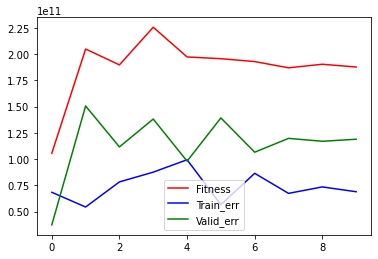

In [68]:
best_fit_gen = np.array(best_fit_gen, dtype = np.double)
best_train_err_gen = np.array(best_train_err_gen, dtype = np.double)
best_valid_err_gen = np.array(best_valid_err_gen, dtype = np.double)
print(best_fit_gen)
print(best_valid_err_gen)
print(best_train_err_gen)
plt.plot(best_fit_gen , color = "red")
plt.plot(best_train_err_gen, color ="blue" )
plt.plot(best_valid_err_gen , color = "green")
plt.legend(["Fitness", "Train_err", "Valid_err"])
plt.show()

In [15]:
import numpy as np
initial_array = [0.0, -1.45799022e-12, -2.28980078e-13,  4.62010753e-11, -1.75214813e-10, -1.83669770e-15,  8.52944060e-16,  2.29423303e-05, -2.04721003e-06, -1.59792834e-08,  9.98214034e-10]
check_arr =    [5.676391085132782e-10, -1.3857292723118332e-12, -2.2653919384209594e-13, 4.634432566014288e-11, -1.8256651150328223e-10, -1.8988854373633673e-15, 7.962947915504994e-16, 2.351580929846117e-05, -2.0282321098290316e-06, -1.56204124253323e-08, 9.43748938900726e-10]
initial_array = np.array(initial_array, dtype = np.double)
check_arr = np.array(check_arr , dtype = np.double)
max_val = initial_array + initial_array/10
max_val = np.clip(max_val,-10,+10)
min_val = initial_array - initial_array/10
min_val = np.clip(min_val,-10,+10)
max_val[0] = initial_array[0] + np.mean(initial_array)/1000
min_val[0] = initial_array[0] - np.mean(initial_array)/1000
for i in range(0,11):
    if ( check_arr[i] >max_val[i] or check_arr [i]<min_val[i]):
        print(i)

1
2
4
5
8
9


In [48]:
best_weights_set

[-4.091882822827459e-12,
 -1.3666199456383565e-12,
 -2.1581806133907695e-13,
 4.269019584928234e-11,
 -1.6507773041067722e-10,
 -1.7148731936706806e-15,
 7.596187431130764e-16,
 2.1511788255729296e-05,
 -1.9149444693608288e-06,
 -1.482336292882705e-08,
 9.170266200526416e-10]

In [4]:
import numpy as np
numbers = np.array([1, 3, 2, 4])

n = 2


indices = (numbers).argsort()[:n]
indices

array([0, 2])